In [192]:
!pip install pandas matplotlib wordcloud scikit-learn seaborn textblob nltk shap

In [194]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
import re
import shap
from sklearn.model_selection import GridSearchCV
from transformers import pipeline
from sklearn.decomposition import LatentDirichletAllocation

In [196]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lizag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lizag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lizag\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lizag\AppData\Roaming\nltk_data...


In [57]:
data = pd.read_csv("universal_studio.csv")

In [59]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50904 entries, 0 to 50903
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   reviewer      50904 non-null  object 
 1   rating        50904 non-null  float64
 2   written_date  50904 non-null  object 
 3   title         50904 non-null  object 
 4   review_text   50904 non-null  object 
 5   branch        50904 non-null  object 
dtypes: float64(1), object(5)
memory usage: 2.3+ MB


,reviewer,rating,written_date,title,review_text,branch
0,Kelly B,2.0,"May 30, 2021",Universal is a complete Disaster - stick with ...,We went to Universal over Memorial Day weekend...,Universal Studios Florida
1,Jon,1.0,"May 30, 2021",Food is hard to get.,The food service is horrible. I’m not reviewin...,Universal Studios Florida
2,Nerdy P,2.0,"May 30, 2021",Disappointed,I booked this vacation mainly to ride Hagrid m...,Universal Studios Florida
3,ran101278,4.0,"May 29, 2021",My opinion,When a person tries the test seat for the ride...,Universal Studios Florida
4,tammies20132015,5.0,"May 28, 2021",The Bourne Stuntacular...MUST SEE,"Ok, I can't stress enough to anyone and everyo...",Universal Studios Florida


In [200]:
data = data.copy() 

data['rating'] = data['rating'].fillna(data['rating'].mean())
data['review_text'] = data['review_text'].fillna('')
data['written_date'] = pd.to_datetime(data['written_date'])

In [120]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

In [122]:
data['cleaned_review'] = data['review_text'].apply(clean_text)

In [202]:
data['cleaned_review'].head()

0    went universal memorial day weekend total trai...
1    food service horrible im reviewing food wait t...
2    booked vacation mainly ride hagrid motorcycle ...
3    person try test seat ride get green light go l...
4    ok cant stress enough anyone everyone go unive...
Name: cleaned_review, dtype: object

In [204]:
sia = SentimentIntensityAnalyzer()
data['vader_sentiment'] = data['cleaned_review'].apply(lambda x: sia.polarity_scores(x)['compound'])
data['sentiment_label'] = data['vader_sentiment'].apply(lambda x: 1 if x > 0 else 0)

In [300]:
def categorize_sentiment(score):
    if score < -0.1:
        return "Negative"
    elif -0.1 <= score <= 0.1:
        return "Neutral"
    else:
        return "Positive"

data['sentiment_category'] = data['vader_sentiment'].apply(categorize_sentiment)

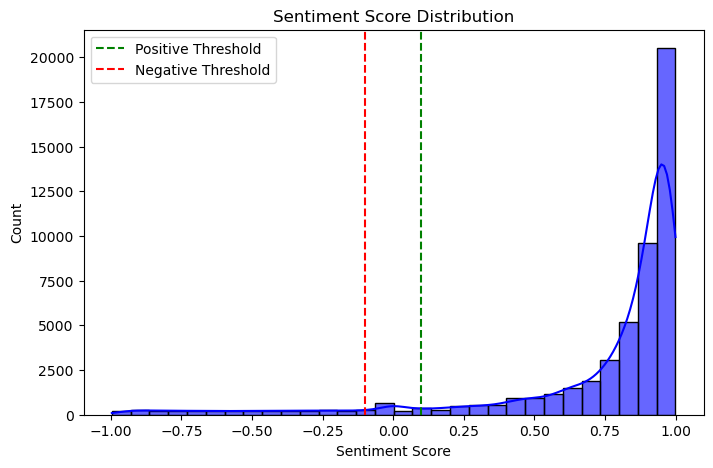

In [310]:
plt.figure(figsize=(8,5))
sns.histplot(data['vader_sentiment'], bins=30, kde=True, color='blue', alpha=0.6)
plt.axvline(0.1, color='green', linestyle='--', label='Positive Threshold')
plt.axvline(-0.1, color='red', linestyle='--', label='Negative Threshold')
plt.title("Sentiment Score Distribution")
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.legend()
plt.show()

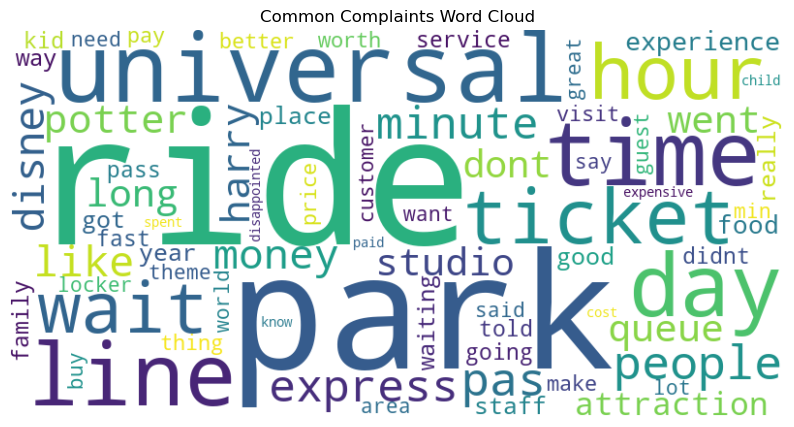

In [208]:
low_rated_reviews = data[data['rating'] <= 2]['cleaned_review']
vectorizer = CountVectorizer(stop_words='english', max_features=70)
complaints_matrix = vectorizer.fit_transform(low_rated_reviews)
complaint_keywords = vectorizer.get_feature_names_out()
complaint_freq = complaints_matrix.toarray().sum(axis=0)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(complaint_keywords, complaint_freq)))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Complaints Word Cloud")
plt.show()

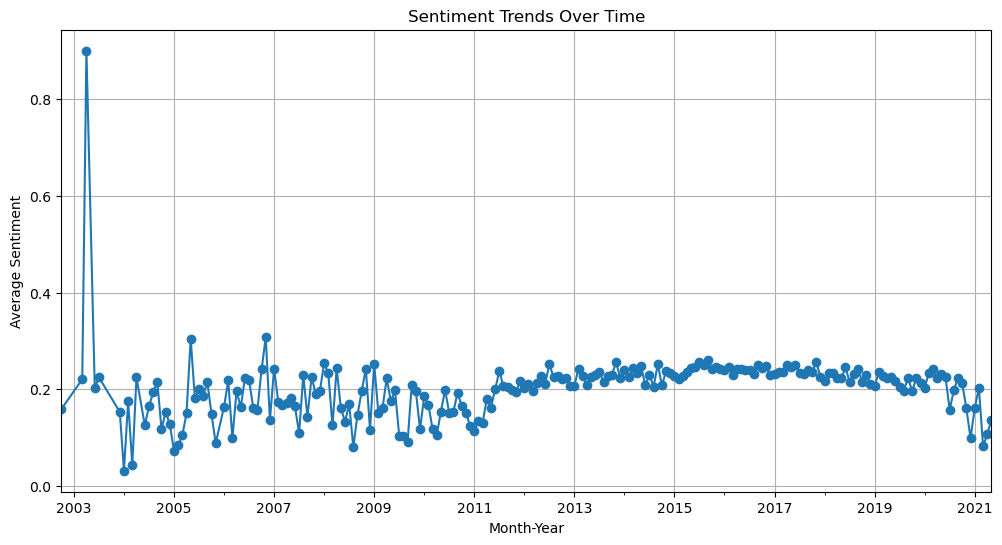

In [256]:
data['month_year'] = data['written_date'].dt.to_period('M')
sentiment_trends = data.groupby('month_year')['sentiment'].mean()
plt.figure(figsize=(12,6))
sentiment_trends.plot(marker='o')
plt.title("Sentiment Trends Over Time")
plt.xlabel("Month-Year")
plt.ylabel("Average Sentiment")
plt.grid()
plt.show()

In [214]:
print(data[['written_date', 'month_year']].head())

  written_date month_year
0   2021-05-30    2021-05
1   2021-05-30    2021-05
2   2021-05-30    2021-05
3   2021-05-29    2021-05
4   2021-05-28    2021-05


In [216]:
data['month_year'] = data['written_date'].dt.to_period('M')

In [218]:
rating_trends = data.groupby('month_year')['rating'].mean()

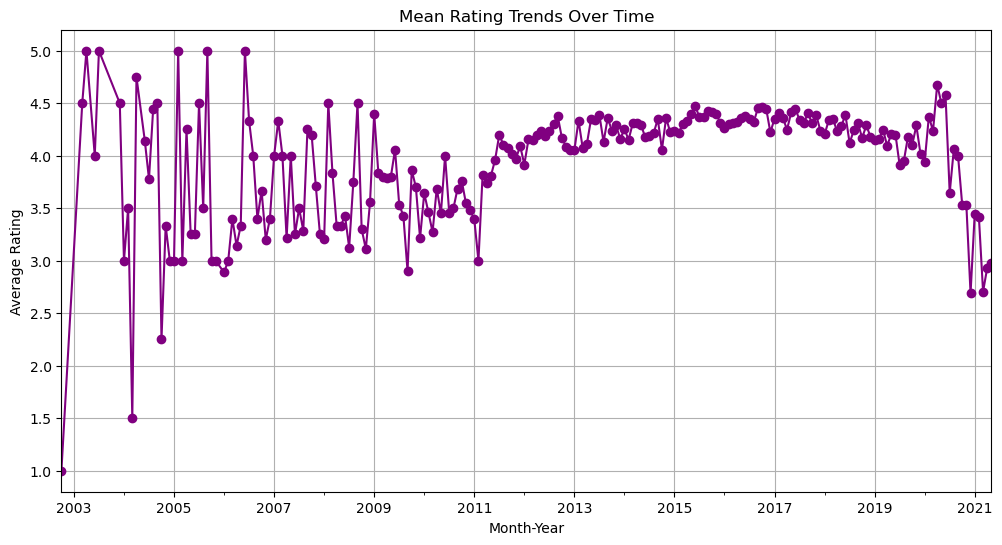

In [258]:
rating_trends = data.groupby('month_year')['rating'].mean()
plt.figure(figsize=(12,6))
rating_trends.plot(marker='o', color='purple')
plt.title("Mean Rating Trends Over Time")
plt.xlabel("Month-Year")
plt.ylabel("Average Rating")
plt.grid()
plt.show()

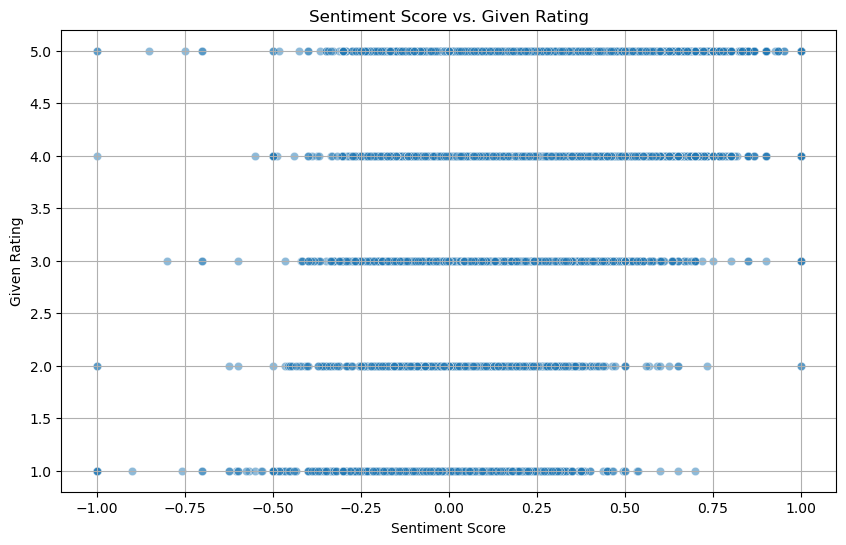

In [260]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=data['sentiment'], y=data['rating'], alpha=0.5)
plt.title("Sentiment Score vs. Given Rating")
plt.xlabel("Sentiment Score")
plt.ylabel("Given Rating")
plt.grid()
plt.show()

In [224]:
mismatched_reviews = data[(data['sentiment'] < 0) & (data['rating'] > 3)]
print("Mismatched Reviews (Negative Sentiment but High Rating):")
print(mismatched_reviews[['review_text', 'rating', 'sentiment']].head())

Mismatched Reviews (Negative Sentiment but High Rating):
                                           review_text  rating  sentiment
95   We flew in from California after we were vacci...     4.0  -0.096548
145  This was our first time at Universal and I was...     5.0  -0.166667
238  If you want to walk around all day and not rid...     5.0  -0.015000
252  The only way to do Universal is with the Expre...     4.0  -0.006944
292  Let me begin by saying they should keep the sa...     4.0  -0.054167


In [346]:
num_mismatched_reviews = mismatched_reviews.shape[0]
print(f"Total number of mismatched reviews: {num_mismatched_reviews}")

Total number of mismatched reviews: 1203


In [344]:
review_index = 252
print("Selected Review Text:")
print(data.iloc[review_index]["review_text"])

Selected Review Text:
The only way to do Universal is with the Express Pass! It hit capacity every day of our trip by 9am. Some rides, we waited 10 minutes, some we waited 30 minutes. THE MOST difficult ride to get on is Hagrid’s Motorbike Adventure. This ride doesn’t take Express Pass. We tried the Virtual Line and were never successful until after 7pm! One day, guest services helped put us on the ride because it was our last day. We made dinner reservations 24 hours in advance. We felt that we did not need a dining plan. We did the breakfast at The Leaky Cauldron and food was decent. There is minimal service there due to Covid. During our trip, we also went to Epcot one day (we had never been), and Universal has managed the whole Covid thing WAY better than Disney. Lines were long there 90-120 minutes waiting time for rides and NO fast passes!


In [90]:
vectorizer = CountVectorizer(max_features=30)
keywords_matrix = vectorizer.fit_transform(data['cleaned_review'])
keywords = vectorizer.get_feature_names_out()
keyword_data = pd.DataFrame(keywords_matrix.toarray(), columns=keywords)
keyword_data['rating'] = data['rating']
correlations = keyword_data.corr()['rating'].sort_values(ascending=False)

In [92]:
print("Top Positive Keywords:")
print(correlations[correlations > 0.05])

print("Top Negative Keywords:")
print(correlations[correlations < -0.05])

Top Positive Keywords:
rating    1.000000
great     0.119970
fun       0.075857
Name: rating, dtype: float64
Top Negative Keywords:
time        -0.051111
rides       -0.052887
good        -0.055404
food        -0.056819
ride        -0.058696
express     -0.064760
go          -0.064990
went        -0.069062
pass        -0.075022
like        -0.077521
universal   -0.089317
one         -0.091918
park        -0.099121
get         -0.106191
wait        -0.109197
long        -0.116057
would       -0.133985
Name: rating, dtype: float64


In [232]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_features=2000)
X = tfidf.fit_transform(data['cleaned_review'])
y = data['sentiment_label']

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [236]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [246]:
param_grid = {'C': [0.01, 0.1, 1, 10]}
log_model = GridSearchCV(LogisticRegression(), param_grid, cv=5)
log_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10]})

In [248]:
predictions = log_model.predict(X_test)

In [250]:
print("Best Hyperparameters:", log_model.best_params_)
print("\nClassification Report:\n", classification_report(y_test, predictions))
print("Accuracy Score:", accuracy_score(y_test, predictions))

Best Hyperparameters: {'C': 10}

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.78      0.56       748
           1       0.98      0.92      0.95      9433

    accuracy                           0.91     10181
   macro avg       0.71      0.85      0.76     10181
weighted avg       0.94      0.91      0.92     10181

Accuracy Score: 0.9099302622532168


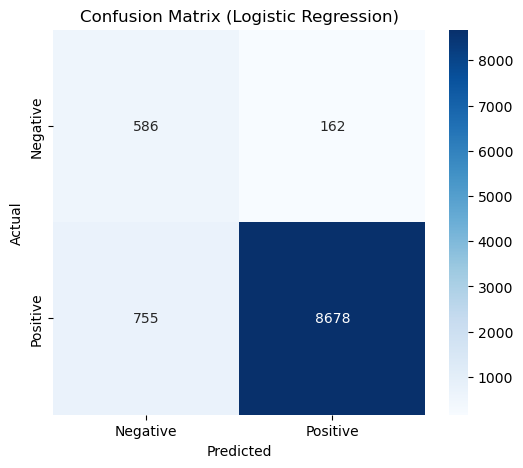

In [252]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [144]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx+1}: ", " , ".join([feature_names[i] for i in topic.argsort()[-num_top_words:]]))

print("Top Topics in Reviews:")
display_topics(lda_model, feature_names, 10)

Top Topics in Reviews:
Topic 1:  pas , disney , line , time , harry , potter , universal , day , ride , park
Topic 2:  year , time , new , simpson , universal , great , harry , potter , park , ride
Topic 3:  family , visit , studio , day , fun , universal , park , great , ride , place
Topic 4:  singapore , queue , time , day , roller , coaster , park , mummy , transformer , ride
Topic 5:  hour , queue , line , day , park , ticket , time , express , pas , ride


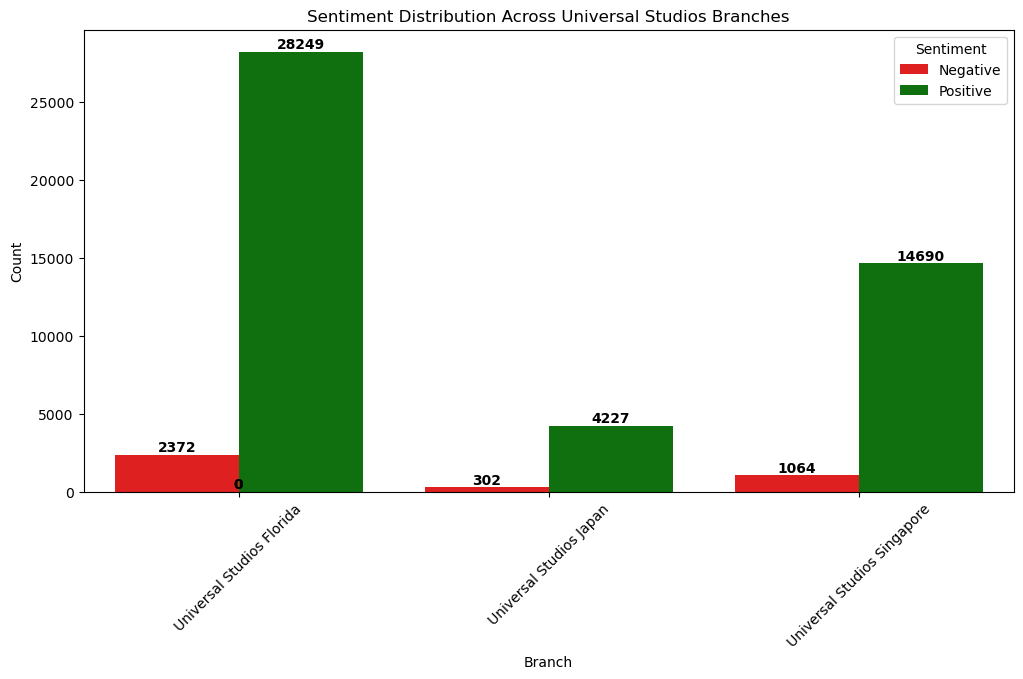

In [352]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='branch', hue='sentiment_label', data=data, palette=['red', 'green'])
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(rotation=45)
plt.title("Sentiment Distribution Across Universal Studios Branches")
plt.xlabel("Branch")
plt.ylabel("Count")
plt.legend(title="Sentiment", labels=["Negative", "Positive"])
plt.show()

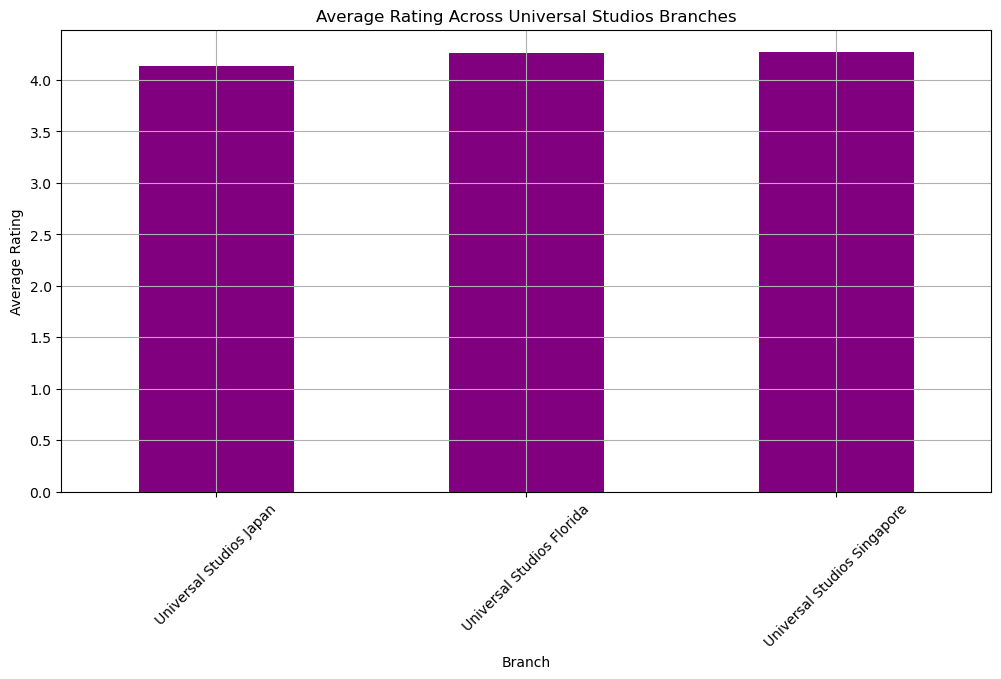

In [264]:
plt.figure(figsize=(12, 6))
branch_ratings = data.groupby("branch")['rating'].mean().sort_values()
branch_ratings.plot(kind='bar', color='purple')
plt.xticks(rotation=45)
plt.title("Average Rating Across Universal Studios Branches")
plt.xlabel("Branch")
plt.ylabel("Average Rating")
plt.grid()
plt.show()

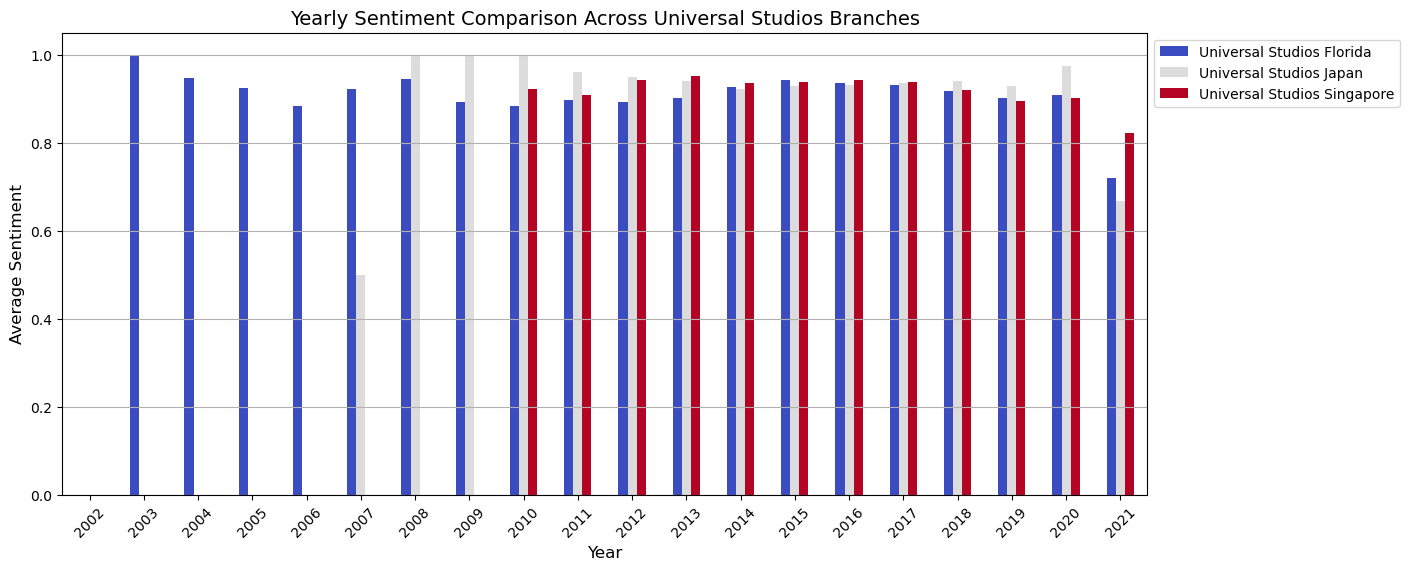

In [282]:
data['year'] = data['written_date'].dt.year
sentiment_by_year = data.groupby(['year', 'branch'])['sentiment_label'].mean().unstack()

sentiment_by_year.plot(kind='bar', figsize=(14, 6), colormap='coolwarm')

plt.title("Yearly Sentiment Comparison Across Universal Studios Branches", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Sentiment", fontsize=12)
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y')
plt.show()

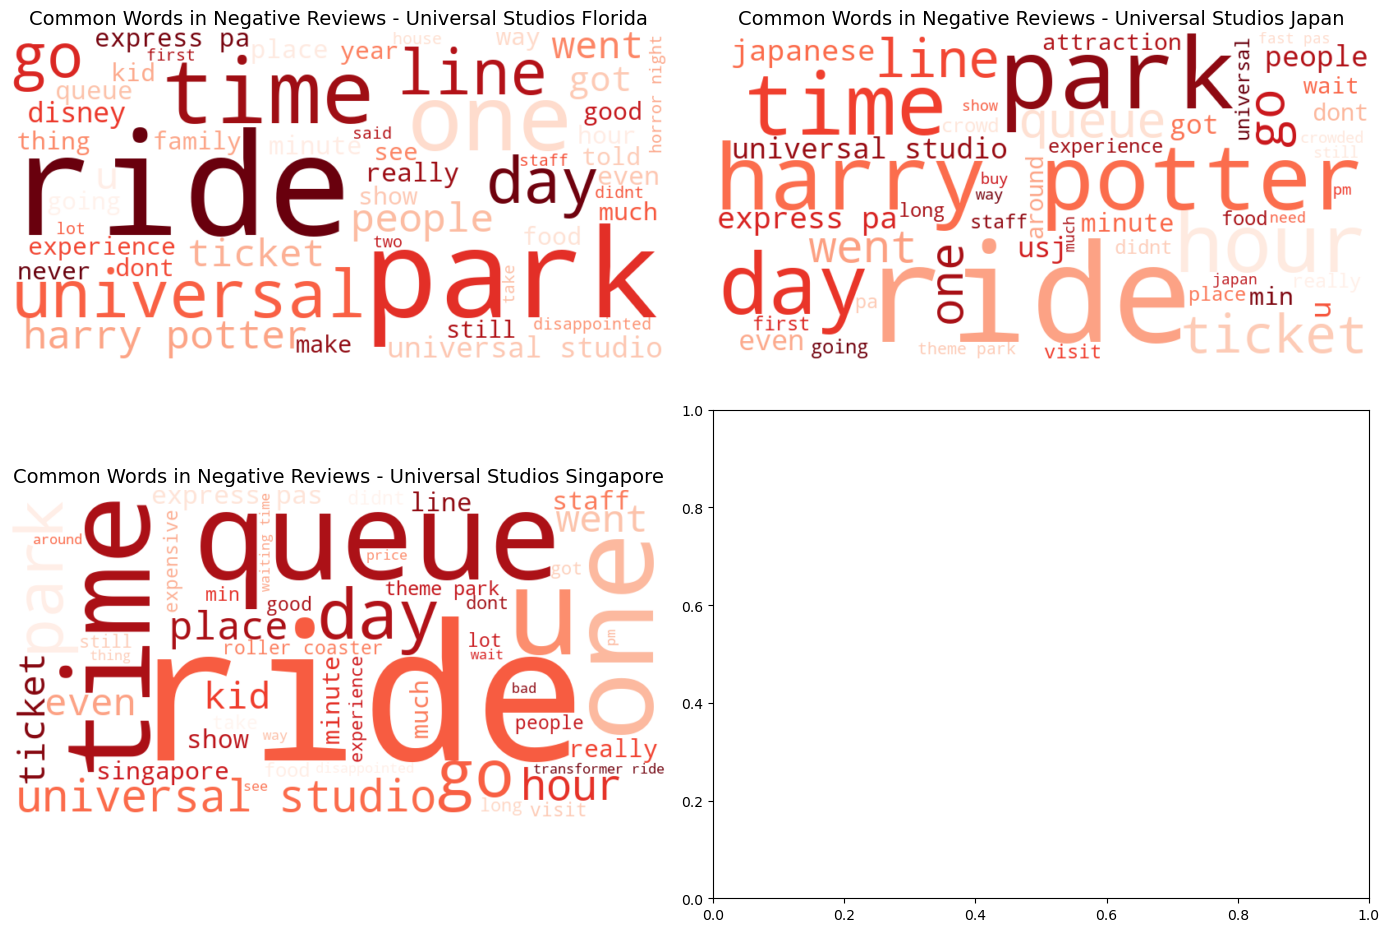

In [354]:
branches = data['branch'].unique()

fig, axes = plt.subplots(nrows=len(branches)//2 + len(branches)%2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

for i, branch in enumerate(branches):
    negative_reviews = " ".join(data[(data['branch'] == branch) & (data['sentiment_label'] == 0)]['cleaned_review'])
    
    wordcloud = WordCloud(
        width=800, height=400, background_color='white',
        max_words=50, colormap='Reds', relative_scaling=0.5
    ).generate(negative_reviews)

    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis("off")
    axes[i].set_title(f"Common Words in Negative Reviews - {branch}", fontsize=14)

plt.tight_layout()
plt.show()